# Imputations methods

## Material

In this notebook we are going to explore different imputation methods

For a more theoretical perspective consider http://www.stat.columbia.edu/~gelman/arm/missing.pdf

We are dealing with data probably belonging to the category missing by design (some values are too expensive to obtain)

Also look at https://www.paultwin.com/wp-content/uploads/Lodder_1140873_Paper_Imputation.pdf

TODO: also take into account more complicated methods that directly tackle the problem of classification such as BoostClean https://arxiv.org/pdf/1711.01299.pdf

For a more detail description check the book "Flexible imputationn of missing data" https://stefvanbuuren.name/fimd/


For discriminative models it is more elaborate, since that is not possible. There are a number of approaches. Gharamani and Jordan http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf describe a principled approach, where missing values are treated like hidden variables, and a variant of the EM algorithm is used to estimate them. In a similar fashion, Smola et al. http://www.gatsby.ucl.ac.uk/aistats/fullpapers/234.pdf describe a variant of the SVM algorithm which explicitly tackles the problem.

In out case the missingness of values is not random but can be an indicator by itself.

For a great summary of existing imputation methods, check the introduction of the paper http://medianetlab.ee.ucla.edu/papers/ICML_GAIN.pdf

First we need to define a little clearer the setting exactly. For startes we are going to deal with only the 5 most common diseases. Also for starters we are merely going to deal with classifying based on the first diagnosis given only. We are going to consider the multiclass classification problem first, but we are should also check the binary classification one to compare with established methods.

## Prepare the data

In [17]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

We will deal with the classification problem only regarding the most common disorders based on all diagnoses given

In [18]:
behaviour_data = pd.read_csv(
    './DataScience2019_MRI/Behavioral/cleaned/HBNFinalSummaries.csv', low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1

# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0]
                         for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [19]:
behaviour_data.shape

(1777, 447)

In [20]:
no_diagnosis_given = 'No Diagnosis Given'
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'No Diagnosis Given',
 'Depressive Disorders',
 'Elimination Disorders']

In [21]:
classes = np.zeros((len(most_common_disorders),
                    behaviour_data.shape[0]), dtype=np.int32)


df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safely remove previous columns describing diagnosis

In [22]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [23]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [24]:
print('Shape', behaviour_data.shape)
behaviour_data.head(5)

Shape (1777, 312)


,Anonymized.ID,EID,Sex,Age,Study.Site,ACE_Score,APQ_P_OPD,APQ_P_Total,APQ_SR_OPD,APQ_SR_Total,...,YSR_SC,YSR_Ext,YSR_Int,YSR_Total,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
0,A00078864,NDARYM832PX3,1,7.048254,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,0,0,0,0
1,A00078865,NDARNJ687DMC,1,6.348163,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,A00078866,NDARRM363BXZ,0,10.052589,1,NaN,NaN,NaN,17.0,118.0,...,NaN,NaN,NaN,NaN,1,0,0,0,0,0
3,A00078867,NDARUW586LLL,1,12.319415,1,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,29.0,85.0,0,0,0,0,1,0
4,A00078868,NDARDC298NW4,0,13.901437,1,NaN,NaN,NaN,33.0,154.0,...,11.0,10.0,26.0,70.0,1,0,0,0,0,0


## Methods to consider

We are going to explore some different imputation methods. More specifically:
1. Do nothing
2. Imputation Using (Mean/Median/Most Frequent) Values
3. Imputation Using k-NN
4. Imputation Using MissForest
5. Expectation Maximization
6. Add features based on whether the value exists or not
7. Autoencoder
8. GAN

In [25]:
import sys
import xgboost as xgb
from missingpy import KNNImputer, MissForest
import impyute as impy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning

In [26]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'EID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

processed = behaviour_data.drop(columns=columns_to_drop)
most_common_disorders = list(most_common_disorders)

In [27]:
from sklearn.model_selection import KFold


def run_binary_classification(dataset, disorders_to_check, clf, imputer, imputer_requires_disorder,
                              drop_missing_threshold, *args):

    conf_matrices = []
    for check_disorder in disorders_to_check:

        if check_disorder == no_diagnosis_given:
            continue

        # only include patients that have that particular disease vs patients that are healthy
        temp = dataset[(dataset[check_disorder] == 1) |
                       (dataset[healthy_diagnosis] == 1)]

        pos = most_common_disorders.index(check_disorder)

        columns_to_drop = most_common_disorders[:pos] + \
            most_common_disorders[(pos + 1):]
        temp = temp.drop(columns=columns_to_drop)

        # drop columns that have only Nan values
        temp = temp.dropna(axis=1, how='all')

        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        kf.get_n_splits(temp)

        preds = np.zeros(temp.shape[0])

        for train_index, test_index in kf.split(temp):
            train, test = temp.iloc[train_index], temp.iloc[test_index]

            if drop_missing_threshold is None:
                drop_missing_threshold = 1  # drop only columns that contain only Nans

            # drop features missing in drop_missing_threshold percent of the time or more
            # The missingpy algorithms to work require that not columsn have more than 80% missing values

            columns_mask = pd.isnull(train).sum() / \
                train.shape[0] >= drop_missing_threshold

            print('Droping this many columns:', np.sum(columns_mask))

            dropped_columns = train.columns[columns_mask]

            train = train.drop(columns=dropped_columns)
            test = test.drop(columns=dropped_columns)

            if imputer_requires_disorder:
                train, test = imputer(train, test, check_disorder, *args)
            else:
                train, test = imputer(train, test, *args)

            clf.fit(train.drop(
                columns=[check_disorder]), train[check_disorder])
            preds[test_index] = clf.predict(
                test.drop(columns=[check_disorder]))

        y_true = temp[check_disorder]

        conf = confusion_matrix(y_true, preds)

        conf_matrices.append(conf)

    return conf_matrices

Before actually droping columns that cannot be incorporated for the next analysis as they are categorical values, we should check their correlation with the predicted classes!

In [29]:
disorder_corr = np.zeros(
    (len(columns_to_drop) - 2, len(most_common_disorders)))

# the disorder to find the correlation for
for index, disorder in enumerate(most_common_disorders):
    dropped_columns_dataset = behaviour_data[columns_to_drop + [
        most_common_disorders[index]]]

    # remove the anonymized id and the EID
    for col in dropped_columns_dataset[2:-1]:
        dropped_columns_dataset[col] = dropped_columns_dataset[col].astype(
            'category').cat.codes

    disorder_corr[:, index] = dropped_columns_dataset[dropped_columns_dataset.columns[2:]].corr()[
        most_common_disorders[index]][:-1].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


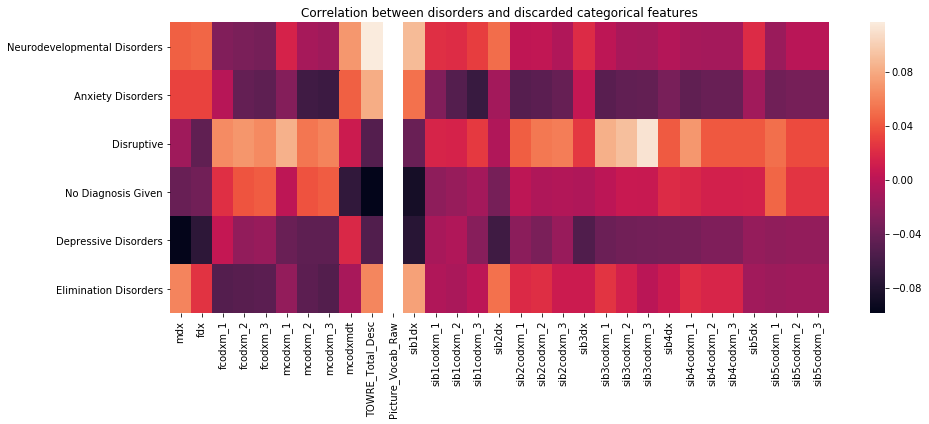

In [30]:
correlation_df = pd.DataFrame(
    disorder_corr.T, columns=columns_to_drop[2:], index=most_common_disorders)
sns.heatmap(correlation_df)

plt.title('Correlation between disorders and discarded categorical features')
plt.ylim([len(most_common_disorders), 0])
plt.tight_layout()

plt.show()

For the next experiments and in order to compare different methods we will use the same classifier:

In [31]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100)

### Do nothing

Some algorithms such as XGBoost can deal with Nans. Careful when comparing accuracy with the other mehtods that all have the same classifier as comparison

In [ ]:
def do_nothing(x, y):
    return x, y


run_binary_classification(processed, most_common_disorders,
                          xgb.XGBClassifier(), do_nothing, False, None)

### Imputation Using (Mean/Median/Most_frequent) Values

In [ ]:
strategy = 'median'


def standard_imputer(x, y, strategy):
    assert strategy in ['mean', 'median', 'most_frequent']
    if strategy == 'mean':
        filling = x.mean()
    elif strategy == 'median':
        filling = x.median()
    elif strategy == 'most_frequent':
        filling = x.mode().iloc[0]

    return x.fillna(filling), y.fillna(filling)


run_binary_classification(processed, most_common_disorders,
                          clf, standard_imputer, False, None, strategy)

### Imputation Using k-NN

The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. This methos from the missingpy library requires that no more than 80\% of the values are missing for a specific column

In [ ]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y


my_inputer = KNNImputer(n_neighbors=5, weights="distance")

run_binary_classification(processed, most_common_disorders,
                          clf, imputer_fun, False, 0.8, my_inputer)

### Imputation using MissForest

The algorithm, for each variable missForest fits a random forest on the observed part and then predicts the missing part. The algorithm continues to repeat these two steps until a stopping criterion is met or the user specified maximum of iterations is reached. 

In [ ]:
def imputer_fun(x, y, my_imputer):
    x_new = my_inputer.fit_transform(x)
    y_new = my_inputer.transform(y)

    x[x.columns] = x_new
    y[y.columns] = y_new
    return x, y


my_inputer = MissForest(max_depth=4, n_estimators=30)

run_binary_classification(processed, most_common_disorders,
                          clf, imputer_fun, False, None, my_inputer)

### Expectation Maximization

In [ ]:
def imputer_em(x, y, disorder):
    # Should we drop here the predicted column or not?
    # We can probably keep them but not particular differerence
    x_values = x.drop(columns=disorder).values
    y_values = y.drop(columns=disorder).values
    total_values = np.concatenate((x_values, y_values), axis=0)

    total_values = impy.em(total_values)

    x.loc[:, x.columns != disorder] = total_values[:x.shape[0]]
    y.loc[:, y.columns != disorder] = total_values[len(
        total_values) - y.shape[0]:]

    return x, y


run_binary_classification(
    processed, most_common_disorders, clf, imputer_em, True, None)

### Add features based on whether the value exists or not

For this part we should take into account which exact features can have Nan values

The features that do not take any null values are 'Sex', 'Age', 'Study.Site' and the disorder we are currently checking for

In [ ]:
def process_dataset(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')

    # change column naming to enable the inner join
    x1.columns = [col + '_existence' for col in x1.columns]
    return x.join(x1)


def data_and_existence_of_features(x, y, disorder):
    cols = ['Sex', 'Age', 'Study.Site', disorder]
    rest_of_columns = list(x.columns.values)
    for c in cols:
        rest_of_columns.remove(c)

    x_new = process_dataset(x, cols)
    y_new = process_dataset(y, cols)

    # finally fill in remaining values with the median as done in the standard method
    x_new[rest_of_columns], y_new[rest_of_columns] = standard_imputer(x_new[rest_of_columns],
                                                                      y_new[rest_of_columns],
                                                                      'median')
    return x_new, y_new


run_binary_classification(processed, most_common_disorders,
                          clf, data_and_existence_of_features, True, None)

### Autoencoder

Before using an autoencoder we should actually scale the data first!

In [ ]:
from sklearn.preprocessing import MinMaxScaler

layers = [50, 25, 25]
learning_rate = 5
masking = 0.15
dropout = 0.
regularization = 8.
n_epochs = 300


def imputer_autoencoder(x, y, disorder):
    original_x_labels = x[disorder].values
    original_y_labels = y[disorder].values

    data = x.values.copy()
    test_data = y.values.copy()
    col_mean = np.nanmean(data, axis=0)

    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    test_data = scaler.fit_transform(test_data)

    data_mask = ~np.isnan(data)
    test_data_mask = ~np.isnan(test_data)

    # fill all nan values with a dummy value
    # in this case we are considering the mean value

    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    inds = np.where(np.isnan(test_data))
    test_data[inds] = np.take(col_mean, inds[1])

    autoencoder = Autoencoder(data.shape[1], layers=layers, masking=masking, regularization=regularization,
                              dropout=dropout)
    autoencoder.fit(data, data_mask, learning_rate=learning_rate,
                    print_every_epochs=1, n_epochs=n_epochs)

    reconstructed_data = autoencoder.reconstruct(data)
    data[~data_mask] = reconstructed_data[~data_mask]

    reconstructed_test_data = autoencoder.reconstruct(test_data)
    test_data[~test_data_mask] = reconstructed_test_data[~test_data_mask]

    x[x.columns] = data
    y[y.columns] = test_data

    # this step should not be really required as these values are not Nan
    # and so they are not replaced during the previous step
    x[disorder] = original_x_labels
    y[disorder] = original_y_labels

    return x, y


conf_matrices = run_binary_classification(
    processed, most_common_disorders, clf, imputer_autoencoder, True, None)

We can also make predictions based on solely the latent space. This does not seem to work well.

In [ ]:
def autoencoder_latent(x, y, disorder):
    original_x_labels = x[disorder].values
    original_y_labels = y[disorder].values

    data = x.values.copy()
    test_data = y.values.copy()
    col_mean = np.nanmean(data, axis=0)

    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    test_data = scaler.fit_transform(test_data)

    data_mask = ~np.isnan(data)
    test_data_mask = ~np.isnan(test_data)

    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    inds = np.where(np.isnan(test_data))
    test_data[inds] = np.take(col_mean, inds[1])

    autoencoder = Autoencoder(data.shape[1], layers=layers, masking=masking, regularization=regularization,
                              dropout=dropout)
    autoencoder.fit(data, data_mask, learning_rate=learning_rate,
                    print_every_epochs=1, n_epochs=n_epochs)

    # only difference is this step here
    latent_data = autoencoder.get_latent_space(data)
    latent_test_data = autoencoder.get_latent_space(test_data)

    data_new = np.concatenate(
        (latent_data, np.expand_dims(original_x_labels, axis=1)), axis=1)
    data_new = pd.DataFrame(data_new, columns=list(
        range(autoencoder.layers[-1])) + [disorder])

    data_test_new = np.concatenate(
        (latent_test_data, np.expand_dims(original_y_labels, axis=1)), axis=1)
    data_test_new = pd.DataFrame(data_test_new, columns=list(
        range(autoencoder.layers[-1])) + [disorder])

    return data_new, data_test_new


conf_matrices = run_binary_classification(
    processed, most_common_disorders, clf, autoencoder_latent, True, None)

### Generative Adversarial model for imputation of missign values

Based on the paper: http://medianetlab.ee.ucla.edu/papers/ICML_GAIN.pdf

TODO: Also try to start also only with columns having values with a threshold regarding the nans in a single column

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [0]:
# find indices of Nan values
mask_nans = (np.sum(pd.isnull(processed)) > 0).values
columns_with_nans = processed.columns[mask_nans]

data_nans = processed[columns_with_nans].values
data_nans = data_nans.copy()

In [0]:
# MODEL PARAMETERS

# Mini batch size
mb_size = 8

# Hint rate
p_hint = 0.9

# Loss Hyperparameters
alpha = 10

# SHOULD WE SPLIT INTO TRAIN AND TEST SET HERE?

In [0]:
Dim = data_nans.shape[1]

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

# scale the data
scaler = MinMaxScaler()
data_nans = scaler.fit_transform(data_nans)

missing = np.isnan(data_nans)

# fill in missing values
data_nans[missing] = 0
missing = 1 - missing.astype(np.int32)

In [0]:
# start defining the graph

tf.reset_default_graph()

In [0]:
# 1. Xavier Initialization Definition
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

# Hint Vector Generation


def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size=[m, n])
    B = A > p
    C = 1.*B
    return C

# %% GAIN Architecture


# %% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape=[None, Dim])
# 1.2. Mask Vector
M = tf.placeholder(tf.float32, shape=[None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape=[None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape=[None, Dim])

# %% 2. Discriminator
D_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]))     # Data + Hint as inputs
D_b1 = tf.Variable(tf.zeros(shape=[H_Dim1]))

D_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]))
D_b2 = tf.Variable(tf.zeros(shape=[H_Dim2]))

D_W3 = tf.Variable(xavier_init([H_Dim2, Dim]))
D_b3 = tf.Variable(tf.zeros(shape=[Dim]))       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

# %% 3. Generator
# Data + Mask as inputs (Random Noises are in Missing Components)
G_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]))
G_b1 = tf.Variable(tf.zeros(shape=[H_Dim1]))

G_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]))
G_b2 = tf.Variable(tf.zeros(shape=[H_Dim2]))

G_W3 = tf.Variable(xavier_init([H_Dim2, Dim]))
G_b3 = tf.Variable(tf.zeros(shape=[Dim]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [0]:
# %% GAIN Function

# %% 1. Generator


def generator(new_x, m):
    inputs = tf.concat(axis=1, values=[new_x, m])  # Mask + Data Concatenate
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    # [0,1] normalized Output
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3)

    return G_prob

# %% 2. Discriminator


def discriminator(new_x, h):
    inputs = tf.concat(axis=1, values=[new_x, h])  # Hint + Data Concatenate
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output

    return D_prob

In [0]:
# %% 3. Other functions
# Random sample generator for Z


def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size=[m, n])

# Mini-batch generation


def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx


# %% Structure
# Generator
G_sample = generator(New_X, M)

# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)

# %% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) +
                          (1-M) * tf.log(1. - D_prob + 1e-8))
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean(
    (M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss

# %% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [0]:
# %% Iterations
# %% Start Iterations


def get_batches(iterable, batch_size=16, do_shuffle=True):
    if do_shuffle:
        iterable = shuffle(iterable)

    length = len(iterable)
    for ndx in range(0, length, batch_size):
        iterable_batch = iterable[ndx: min(ndx + batch_size, length)]
        yield iterable_batch


print_every_epochs = 20

sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 300
for epoch in range(n_epochs):

    for mb_idx in get_batches(range(data_nans.shape[0]), batch_size=mb_size):
        # %% Inputs
        X_mb = data_nans[mb_idx, :]

        Z_mb = sample_Z(len(mb_idx), Dim)
        M_mb = missing[mb_idx, :]
        H_mb1 = sample_M(len(mb_idx), Dim, 1-p_hint)
        H_mb = M_mb * H_mb1

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

        _, D_loss_curr = sess.run([D_solver, D_loss1], feed_dict={
                                  M: M_mb, New_X: New_X_mb, H: H_mb})
        _, G_loss_curr, MSE_train_loss_curr = sess.run([G_solver, G_loss1, MSE_train_loss],
                                                       feed_dict={X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})

    # %% Intermediate Losses
    if epoch % print_every_epochs == 0:
        print('Epoch: {:3d} train_loss {:.4}'.format(
            epoch, np.sqrt(MSE_train_loss_curr)))

data_reconstructed = np.zeros(data_nans.shape)

# reconstruct
for mb_idx in get_batches(range(data_nans.shape[0]), batch_size=32):
    # %% Inputs
    X_mb = data_nans[mb_idx, :]

    Z_mb = sample_Z(len(mb_idx), Dim)
    M_mb = missing[mb_idx, :]

    reconstructed = sess.run(G_sample, feed_dict={New_X: X_mb, M: M_mb})
    data_reconstructed[mb_idx] = reconstructed * (1 - M_mb) + X_mb * M_mb

# reconstruct data
data_reconstructed_transformed = scaler.inverse_transform(data_reconstructed)

processed_gan = processed.copy()
processed_gan[columns_with_nans] = data_reconstructed_transformed

We can now as before make predictions on the new filled dataset. We can also make predictions based on the dataset together with the boolean dataset of whether a value is nan or not

In [ ]:
def do_nothing(x, y):
    return x, y


def process_dataset(x, cols):
    x1 = x.drop(columns=cols).isna().astype('int32')

    # change column naming to enable the inner join
    x1.columns = [col + '_existence' for col in x1.columns]
    return x.join(x1)


processed_with_existence = process_dataset(
    processed, cols=['Sex', 'Age', 'Study.Site'] + most_common_disorders)
processed_with_existence[columns_with_nans] = data_reconstructed_transformed

run_binary_classification(
    processed_gan, most_common_disorders, clf, do_nothing, False, None)

## Results

We will now present some of the results of the above process. For this we can consider different metrics. In our case we will consider the f1 score to account for classes imbalances. We will then get the mean f1 score across the different problems considered

In [51]:
from sklearn.metrics import f1_score, confusion_matrix

In [97]:
# function to convert printed arrays to appropriate format
def convert(arr):
    nums = [float(s) for s in re.findall(
        "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", arr)]
    conf = np.array(nums).reshape(5, 2, 2)
    return repr(conf).replace('\n', "").replace(" ", "")


# data acquired
conf_nothing = np.array([[[94, 141], [40, 1265]], [[173,  62], [58, 369]], [
                        [201, 34], [36, 237]], [[212, 23], [22, 152]], [[210, 25], [42, 46]]])
conf_mean = np.array([[[83.4, 151.6], [25., 1280.]], [[162.4, 72.6], [47.2,  379.8]], [[199.6,   35.4],   [
                     33.8,  239.2]], [[210.6,   24.4], [22.6,  151.4]], [[218.8, 16.2], [49.4,   38.6]]])
conf_median = np.array([[[82.2, 152.8], [27.2, 1277.8]], [[161.8, 73.2], [48.4, 378.6]], [
                       [201.2, 33.8], [30.6, 242.4]], [[210.8, 24.2], [22., 152.]], [[220., 15.], [49.4, 38.6]]])
conf_most_freq = np.array([[[81., 154.], [28.2, 1276.8]], [[162.8, 72.2], [42., 385.]], [
                          [197.4, 37.6], [28.2, 244.8]], [[209.6, 25.4], [23.6, 150.4]], [
    [220.4, 14.6], [50.2, 37.8]]])
conf_missforest = np.array([[[40., 195.], [12., 1293.]], [[119., 116.], [27., 400.]], [
                           [192., 43.], [33., 240.]], [[210., 25.], [22., 152.]], [[223., 12.], [57., 31.]]])
conf_plus_existence_median = np.array([[[77.4, 157.6], [22.4, 1282.6]], [[159.4, 75.6], [41.4, 385.6]], [
                                      [196.6, 38.4], [28.2, 244.8]], [[210.2, 24.8], [19.8, 154.2]], [
    [218.2, 16.8], [47.4, 40.6]]])
conf_only_existence = np.array([[[37., 198.], [55., 1250.]], [[92., 143.], [107., 320.]], [
                               [127., 108.], [103., 170.]], [[173., 62.], [66., 108.]], [[199., 36.], [56., 32.]]])
conf_knn = np.array([[[79.9, 155.1], [23.7, 1281.3]], [[156.5, 78.5], [48.4, 378.6]], [
                    [198.3, 36.7], [34.1, 238.9]], [[207.8, 27.2], [24.7, 149.3]], [[219., 16.], [52.9, 35.1]]])
conf_em = np.array([[[13., 222.], [6., 1299.]], [[129., 106.], [38., 389.]], [
                   [195., 40.], [28., 245.]], [[211., 24.], [32., 142.]], [[223., 12.], [60., 28.]]])

# layers=[50, 25, 25], learning_rate=5, masking=0.15, dropout=0., regularization=8., mean initial, n_epochs=300
conf_autoencoder = np.array([[[59., 176.], [14., 1291.]], [[147., 88.], [29., 398.]], [
                            [190., 45.], [23., 250.]], [[205., 30.], [17., 157.]], [[219., 16.], [54., 34.]]])

# learning_rate=0.00003, epochs=300
conf_gan = np.array([[[66., 169.], [14., 1291.]], [[155., 80.], [39., 388.]], [
                    [199., 36.], [31., 242.]], [[211., 24.], [22., 152.]], [[214., 21.], [52., 36.]]])
conf_gan_plus_existence = np.array([[[70., 165.], [16., 1289.]], [[147., 88.], [38., 389.]], [
                                   [199., 36.], [31., 242.]], [[212., 23.], [23., 151.]],
    [[217., 18.], [53., 35.]]])

In [123]:
def f1_score_from_conf_matrix(conf):
    precision = conf[0][0] / (conf[1][0] + conf[0][0])
    recall = conf[0][0] / (conf[0][1] + conf[0][0])

    class_0_f1 = 2 * precision * recall / (precision + recall)
    
    precision = conf[1][1] / (conf[0][1] + conf[1][1])
    recall = conf[1][1] / (conf[1][0] + conf[1][1])

    class_1_f1 = 2 * precision * recall / (precision + recall)

    return (class_0_f1 + class_1_f1) / 2

def calculate_balanced_f1(conf_experiment):
    return np.mean([f1_score_from_conf_matrix(x) for x in conf_experiment])

In [124]:
calculate_balanced_f1(conf_autoencoder)

0.7752169600939477

In [125]:
[f1_score_from_conf_matrix(x) for x in conf_autoencoder]

[0.6572871572871573,
 0.793589753839512,
 0.8642479879275653,
 0.8834807276165768,
 0.6774791737989273]

In [126]:
conf_autoencoder[0]

array([[  59.,  176.],
       [  14., 1291.]])

In [113]:
precision = 1291 / (1291 + 176)
recall = 1291 / (1291 + 14)